In [1]:
# importando as bibliotecas padrão para o tratamento dos dados

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from pandas_datareader import data as web

%matplotlib inline

# puxando os dados dos preços diários de fechamento ajustado da COGNA em um prazo de 5 anos via API do Yahoo Finance

ticker = ['COGN3.SA']
acao = web.DataReader(ticker, data_source = 'yahoo', start = '2015-01-01')['Adj Close']
acao = pd.DataFrame(acao)
acao.head()

Symbols,COGN3.SA
Date,
2015-01-02,13.185506
2015-01-05,12.223323
2015-01-06,11.403680
2015-01-07,11.234408
2015-01-08,12.116411


In [2]:
# Calculando os retornos logarítmicos diários com o uso da função np.log da biblioteca Numpy
# Nesse caso, poderia ser mais adequado utilizar o retorno simples se estivéssemos analisando mais de um ativo

log_retorno = np.log(acao / acao.shift(1))

# Em seguida, prosseguimos com o cálculo da média e variância dos retornos diários
# Essas medidas serão de grande utilidade para obtermos o componente drift(desvio) do nosso modelo

u = log_retorno.mean()
var = log_retorno.var()

In [3]:
# Como iremos trabalhar com matrizes, é necessário converter os valores obtidos acima no tipo array
# Para isso, também poderiamos utilizar np.array(nome_da_variavel)
u.values
var.values

array([0.00119917])

In [4]:
# Agora sim começaremos a criar a simulação. A primeira coisa a se fazer é definir o numero de observações e iterações
# Nesse caso, julguei adequado trabalharmos com mil observações de preços e 10 iterações, criando uma matriz 1000x10
# Quanto mais iterações maior o conjunto de simulações, quanto maior o número de observações maior o número de dados gerados

numero_de_observacoes = 1000
iteracoes = 10

# Devemos proceder da mesma forma com o cálculo do drift, que mensura o quanto a média diária se desvia de meia variância.
# Como estamos trabalhando com arrays numpy, também convertemos a variável drift para o tipo array

drift = u - (0.5 * var)
drift.values

# O mesmo raciocínio explicado acima para o drift se aplica também para o desvio-padrão da amostra de log retornos

stdev = log_retorno.std()
stdev.values

array([0.0346291])

In [5]:
# Agora, para obtermos nossa simulação é necessário entender alguns conceitos...
# O primeiro é que o preço futuro = preço atual x fator
# Esse fator corresponde à e^r, já que estamos trabalhando com retornos logarítmicos, ln(preço futuro / preço atual) = r
# O componente r é composto de um desvio(drift) e volatilidade(z.σ), logo, r = drift + z.σ
# O termo norm.ppf da biblioteca scipy.stats é ideal para obtermos os z-scores de números gerados aleatóriamente.

retornos_diarios = np.exp(drift.values + stdev.values * norm.ppf(np.random.rand(numero_de_observacoes, iteracoes)))
retornos_diarios

array([[0.99388254, 1.05172081, 0.95664422, ..., 1.06893451, 1.00331477,
        1.02994162],
       [0.97093706, 1.01162547, 0.94042494, ..., 0.97524998, 0.94815246,
        0.93430007],
       [0.97296574, 0.98935335, 1.00402841, ..., 1.0219176 , 1.03234392,
        0.96363762],
       ...,
       [1.0120426 , 1.03956013, 0.93576188, ..., 1.04537661, 0.96176643,
        1.02882235],
       [0.93360584, 1.01491795, 1.00297467, ..., 1.00600492, 0.99908077,
        0.97959008],
       [0.98161397, 1.02739573, 0.98206754, ..., 0.97500284, 0.91794694,
        1.00823896]])

In [6]:
# Em seguida, devemos definir o preço atual como o último preço de fechamento disponivel. Afinal, queremos simular preços futuros.

S0 = acao.iloc[-1]
S0

Symbols
COGN3.SA    4.5
Name: 2020-11-06 00:00:00, dtype: float64

In [7]:
# Agora, devemos criar uma matriz vazia com as mesmas dimensões do nosso array retornos_diarios.
# Podemos fazer isso utilizando a função np.zeros_like da Numpy

lista_de_precos = np.zeros_like(retornos_diarios)
lista_de_precos

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [8]:
# Agora, preenchemos o primeiro conjunto de dados com o último preço S0 disponível
lista_de_precos[0] = S0

In [9]:
lista_de_precos

array([[4.5, 4.5, 4.5, ..., 4.5, 4.5, 4.5],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ]])

In [10]:
# Como queremos simular, devemos ter como base S0 e preencher o restante do array lista_precos
# Uma das formas de atingir esse objetivo é criando um laço que, para cada elemento t no range entre a segunda fileira e a linha 1000, calcularemos o preço da ação
# Ele será dado pela expressão que vimos no início: Preço hoje = preço ontem x retorno_diario
# Assim, iremos preencher toda a matriz lista_de_precos que antes era vazia, agora com os preços que obtivermos na simulação
# Nosso trabalho está praticamente todo feito, bastando agora plotarmos o resultado em um gráfico na sequência

for t in range(1, numero_de_observacoes):
    lista_de_precos[t] = lista_de_precos[t - 1] * retornos_diarios[t]

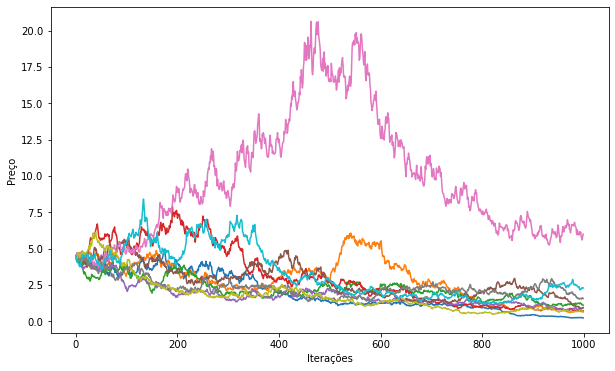

In [11]:
# Aqui, vamos analizar o resultado da nossa Simulação de Monte Carlo!
# Vale ressaltar que, cada vez que você rodar esse código irá obter um resultado distinto!
# Isso ocorre pois a simulação leva como parâmetros funções que geram números aleatórios, e a chance de uma matriz com 10 mil elementos gerados dessa forma ser igual é praticamente nula.
# Para o caso da COGN3, o mais importante ao analisarmos o resultado é ter cuidado e primeiro entender que se trata de uma simulação
# Você poderá observar por si mesmo que, por mais que rode o código novamente, grande parte das 10 iterações que fizemos irá se encontrar próxima ou abaixo do preço atual
# Embora isso não seja recomendação nem de compra e nem de venda do ativo, podemos inferir com base no modelo que a probabilidade do ativo valorizar é discreta.

plt.figure(figsize=(10,6))
plt.plot(lista_de_precos);
plt.xlabel('Iterações')
plt.ylabel('Preço')
plt.show()